# Paul Abers

# CS 637

# Homework 3

This project uses shakespeare text to train the RNNs. Below is a short excerpt of what the shakespeare data looks like:
<br><br>
Second Citizen:<br>
One word, good citizens.<br>
<br>
First Citizen:
We are accounted poor citizens, the patricians good.<br>
What authority surfeits on would relieve us: if they<br>
would yield us but the superfluity, while it were<br>
wholesome, we might guess they relieved us humanely;<br>
but they think we are too dear: the leanness that<br>
afflicts us, the object of our misery, is as an<br>
inventory to particularise their abundance; our<br>
sufferance is a gain to them Let us revenge this with<br>
our pikes, ere we become rakes: for the gods know I<br>
speak this in hunger for bread, not in thirst for revenge.<br>
<br>
Second Citizen:<br>
Would you proceed especially against Caius Marcius?<br>
<br>
All:<br>
Against him first: he's a very dog to the commonalty.<br>

I created both a vanilla rnn from scratch and an lstm rnn with pytorch to attempt to generate shakespeare text. 

## Part 1: Vanilla RNN

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from rnn import RNN, load_perfs_only_file

First I created from scratch using just numpy a Vanilla RNN. An arbitrary shape of hidden layers can be passed on initialization. My computer's processing limitations meant that I could not make the network too complex. I used 3 hidden layers with 128 nodes each. It took a long time to run and seemed to do the best (overall performance is still limited as discussed later). I had 1'000'000 epochs and saved the neural networks state every 1000 epochs with its text generation and loss at each epoch. I then created a pickle file that has the saved losses, texts and epoch number to create a plot here and show its progression through training.

Below is a short demonstration of the RNN call and run.

In [2]:
data = open('shakespeare.txt', 'r').read()

rnn = RNN((128,128,128,),
          num_epochs=20,
          progress_epoch=10,
          track_epoch=False,
          filename_states="",
          seq_length=25,
          save_progress=False)
rnn.train(data)


iter 0, loss: 104.3596816700094
----
 zpJLKfJADn,PMY$ hV-MVJ-3C
jgs-cjbJH.y,gstvf.VPfRpNlwjmiqFznl'IC,uctWuveUBunIfc,v
pVpY3SsB-Ooizs:ni?nCREQGfo
N3
zfQPqZlvs'TdRFutqvkMUpufatlusI.hwuvsPwdpFU-3owWTwp;!wXeWktzKVsPKyjUnHaii?zlkaJTO-vU!OO'?& 
----
.........
iter 10, loss: 105.81850349973794
----
 W,bWW,:kW,''W,'WWW:WWt'WWo'sWo'tW,'AWt:AWo''Wo'AW,'eW,:WW,
'WW''Wo:'W,:'Wo:'W,:AW,''Wo'WW,AAWok'W,:'W,:WW,A'W,ApW,''Wo:tW,:'Wo'AWo'tu,''Wo:'WlkWW,'AWWkmW,'tWo'AW,'WW,:sWh'AWg''W,''Wo'AW,'AW?'tW,'tW,:A 
----
.........

Now lets read in the long runs performances

In [3]:
losses, gens, epochs = load_perfs_only_file("rnn_shakespeare_long_perfs.p")

Below is a plot for loss versus epoch

Text(0.5, 1.0, 'Loss vs Epoch')

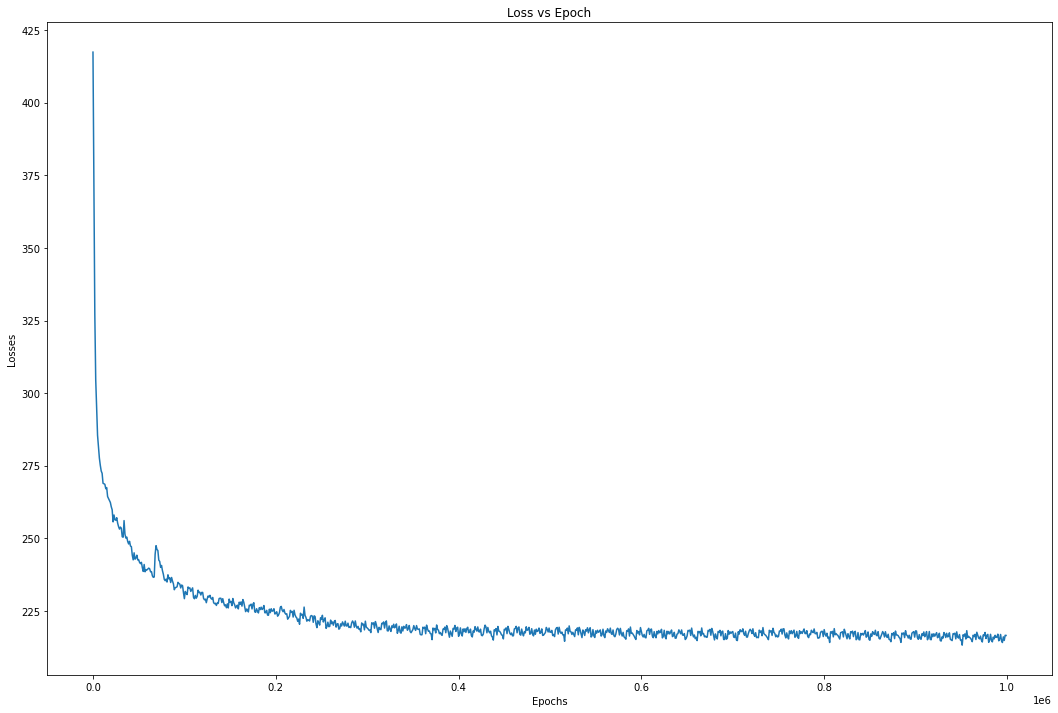

In [4]:
plt.figure(figsize=(18,12))
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss vs Epoch")

Below is several generated texts created by the RNN at various epochs to show its performance progression.

In [5]:
def show_gen(i, texts, epochs):
    print(f"\n{8*'='} Epoch {epochs[i]} {'='*8}\n")
    print(texts[i])
    print("\n\n")

At initialization the text generated is complete gibberish with no structure

In [6]:
show_gen(0, gens, epochs)


======== Epoch 0 ========

zpKMLfJAEn,PNY$ hW-MWK-3C
jhs-cjcKI.y-gstuf.WQgRpOlwjliqFznl'ID-uctXuveUBumJfc,v
pVpY3SsB-Ooizs:ni?mCRERGfo
N3 ygRPqZkus,TdSFutqvkMUpufatlusI.hvuusQvepGU-3owWTwp;!wXeXktzLWsQKyjVnHaii?zlkaJUP-uV!PP'?&





At the 1000 epoch we start to see some improvement:

In [7]:
show_gen(1, gens, epochs)


======== Epoch 1000 ========

: trs otv ee, Toomsrswlrstltioeyaaafrwnohte:Hs ie.bsb nsl 

gOI:ios
l.r!bsn
,aso,ag gsernetfrstb;gtca orsit mhttwee.lssymWnedoIl t uya 
 to woupe 
RNOhlIAIttuahed sdentoo naoe slaenohk  amfn,wn Swv so





And near the end we start to see some words being created and more proper structure.

In [8]:
show_gen(996, gens, epochs)


======== Epoch 996000 ========

;sm the songeut on eto reds, I s meney
as your ule.

KING VIO
IF gEUCENTIA:
Hodlland deilns baoats foals lidirethe lerming,
Yake the bimeaut thit prattir, tule orny urao mess? Thilg Harry in Thacgecs,





What we can see is that the vanilla rnn is able to start to learn some information and structure from the shakespeare input text, but there is still a lot of gibberish. I am not positive that this is not just an error in my code but I have been unable to find anything wrong with my code. What I believe to be the problem is that the vanilla rnn has no memory beyond the previous char. Therefore, it is hard for the rnn to properly form words, sentences and structure as each character only looks at the prior character and current character to predict the next. Sometimes this works and we can get an actual word, but often the rnn generates a bad output. We do still see significant improvement from the first runs of the rnn to the end. By the end the rnn starts to understand that an actor is titled and followed by a colon before having his/her words printed. What we need though is better memory to start to create valid text. Thus, we move on to using LSTMs.

## Part 2: LSTM with PyTorch

PyTorch is used to create a character rnn for generating shakespeare output. The hope is that the stronger and longer memory functionality offered by LSTMs will help us generate more meaningful text compared to the vanilla rnn. 

In [9]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from rnn_pytorch_helper import one_hot_encode, get_batches, train_lstm, generate, save_torch_state, load_torch_state

Read in data (shakespeare text) and encode the inputs

In [10]:
with open('shakespeare.txt', 'r') as f:
    text = f.read()
    
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# Encode the text
encoded = np.array([char2int[ch] for ch in text])

Setup our character rnn with pytorch. We allow the user to specify the number of layers and and hidden nodes for the lstm netowrk

In [11]:
class LSTM(nn.Module):
    
    def __init__(self, tokens, n_hidden=512, n_layers=3, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hid = n_hidden
        self.lr = lr
        
        # creating alphabet and encoders
        self.alphabet = tokens
        self.int2char = dict(enumerate(self.alphabet))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        # create the lstm layers
        self.lstm = nn.LSTM(len(self.alphabet), self.n_hid, self.n_layers, dropout=self.drop_prob, batch_first=True)
        
        # create a dropout layer for post lstm
        self.dropout = nn.Dropout(self.drop_prob)
        
        # create a fully connected feed forward layer
        self.fc = nn.Linear(self.n_hid, len(self.alphabet))
        
    def forward(self, x, hidden):
        """Forward pass
                
        x is the inputs
        hidden are the hidden node states
        """         
        # pass through the lstm layer
        lstm_out, hidden = self.lstm(x, hidden)
        # pass through dropout layer
        dropout_out = self.dropout(lstm_out)
        # reshape outputs for fully connected layer
        out = dropout_out.contiguous().view(-1, self.n_hid)
        # pass through the fully connected layer
        out = self.fc(out)
        # return final output and the hidden states
        return out, hidden

    def init_hidden(self, batch_size):
        """ Initialize hidden state"""
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.n_hid).zero_(),
                  weight.new(self.n_layers, batch_size, self.n_hid).zero_())
        return hidden

In [12]:
# create our LSTM network
n_hidden=512
n_layers=3

net = LSTM(chars, n_hidden, n_layers)

# hyperparameters
batch_size = 128
seq_length = 100
n_epochs = 50

# setup loss and optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# train the model
train_loss, val_loss, gen_texts = train_lstm(net, 
                                             encoded,
                                             opt,
                                             criterion,
                                             epochs=n_epochs, 
                                             batch_size=batch_size, 
                                             seq_length=seq_length)

Epoch: 1/50... Step: 1... Loss: 4.1666... Val Loss: 4.1273
Epoch: 2/50... Step: 79... Loss: 3.3003... Val Loss: 3.3124
Epoch: 3/50... Step: 157... Loss: 2.8779... Val Loss: 2.7971
Epoch: 4/50... Step: 235... Loss: 2.6196... Val Loss: 2.5384
Epoch: 5/50... Step: 313... Loss: 2.3650... Val Loss: 2.2735
Epoch: 6/50... Step: 391... Loss: 2.2092... Val Loss: 2.1238
Epoch: 7/50... Step: 469... Loss: 2.1007... Val Loss: 2.0273
Epoch: 8/50... Step: 547... Loss: 2.0049... Val Loss: 1.9455
Epoch: 9/50... Step: 625... Loss: 1.9391... Val Loss: 1.8776
Epoch: 10/50... Step: 703... Loss: 1.8643... Val Loss: 1.8314
Epoch: 11/50... Step: 781... Loss: 1.8108... Val Loss: 1.7748
Epoch: 12/50... Step: 859... Loss: 1.7715... Val Loss: 1.7328
Epoch: 13/50... Step: 937... Loss: 1.7221... Val Loss: 1.6979
Epoch: 14/50... Step: 1015... Loss: 1.6957... Val Loss: 1.6679
Epoch: 15/50... Step: 1093... Loss: 1.6620... Val Loss: 1.6369
Epoch: 16/50... Step: 1171... Loss: 1.6405... Val Loss: 1.6168
Epoch: 17/50... S

Plot the loss versus epoch

Text(0.5, 1.0, 'Loss vs Epoch')

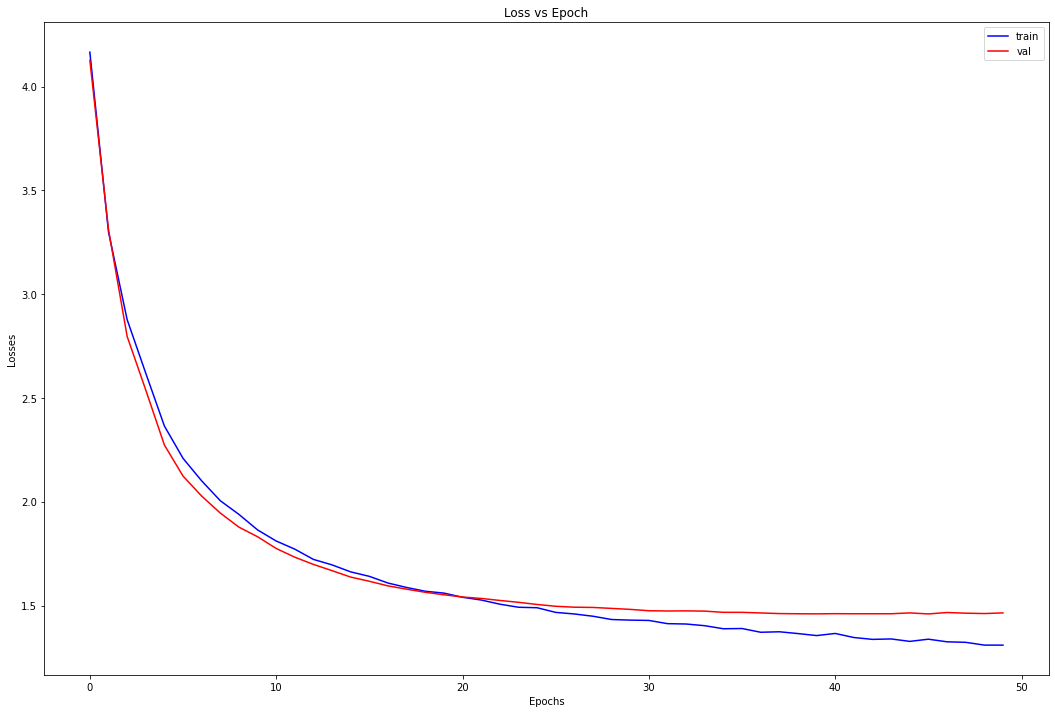

In [18]:
plt.figure(figsize=(18,12))
plt.plot([*range(n_epochs)], train_loss, "b", label="train")
plt.plot([*range(n_epochs)], val_loss, "r", label="val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss vs Epoch")

The train and val loss seem to match for the duration of the training. By the end, it appears we are starting to achieve some overfitting as validation loss has flatlined as training loss continues to decrease. There is no need to continue training.

And various snippets of code produced while training.

In [19]:
show_gen(0, gen_texts, [*range(n_epochs)])


======== Epoch 0 ========

A ,H H
 ttitr
 
ri r
itt rrr itttrr i
t  
titr  it riri
 
 tit 
t
titirtir t i itr i
ittt tir
r 
i
ttti
it


 triirrrt i


 t 
 itit
t
ttiiirt
r i 
tiiiri
r
r  
r r ir 
r
 
  t
 irittr t
tr
irtr    ttrt





In [20]:
show_gen(3, gen_texts, [*range(n_epochs)])


======== Epoch 3 ========

A:Tehes sion set han siut. Inet to that sot mo sirn tetee tatse thet,
Tnal aer he mane sore aod aots she hhe ters aerhle,
Wot ter sae tart the tertennee tan tie taes soae tors,
Tor seeee wo hon teaeere 





In [21]:
show_gen(10, gen_texts, [*range(n_epochs)])


======== Epoch 10 ========

As
The wouldss with he dear to him have they;
And with hast the cansot sick of hears
And wouls the chorses and his bory,
And thy where it the stay with the pitions.

GOREO:
That I was with the strungers





And now a final text generation after we finish training. Note we only did 50 epochs (due to computing limitations). The performance may continue to improve with further epochs for training.

In [29]:
print(generate(net, 1000, prime='A', top_k=5))

AGUL:
I think that would not let thee here take thee.

KING RICHARD III:
Why, set thy suns to the cipy which we will buside
Whose bleast to me, if he dare never hardly
To bear a world as hand and dead and will;
And that hath died his fetch and woman's death;
Which since thou hath shear'd; and, bying such a person
With me, and teach his blows of thriving storms:
But, by the sea, a boater on the world
Is thought their sins, thou deserved him of my second.

CLARENCE:
I'll be a passage of an oad or doubt,
And walk and thrive a body with the world.

KING RICHARD III:
To me the sea, and where they were a person,
That I have hope in them a prisoner shame
Which if more beauties and mark my subjects as
Where I may shake it in my foul will speak.

KING EDWARD IV:
Trania, my lord, my sin be they shall see:
In most dear bland is as it shall be tongue,
And made a party to myself was so,
All senses of these bornes than thy shame;
Whose thing then we should danger take the cast,
Or some of you to the

As can be seen, the LSTM does quite well. The syntax structure, grammar and vocab all appear fine to the human eye. The meaning of the words and sentences are not perfect but overall it is a good performance.

I have saved the final torch state and allow a user to load in the final torch state as well to generate text if a user wants to test/use the RNN without having to wait for the training to complete. Below is an example of the save (commented out) and the load with another call to print the text generated. Note it uses the exact same LSTM class above but the LSTM is copied into the rnn_pytorch_helper.py so the above LSTM class should not be changed in any way to prevent breaking the save/load ability below.

In [47]:
#save_torch_state("torch_final.state", net)
new = load_torch_state("torch_final.state")

In [48]:
print(generate(new, 1000, prime='A', top_k=5))

AND:
And then when this think you hear there is nor short.
If the beggary that they will see the citizens
Is those some man which was a brown is sprong,
That so that's thine against the sun at love,
That stands as shines to my stock things.

MERCUTIO:
I would I speak now to his fatal sights.
Why, who did stand in traitors? What say you?

ABHORSON:
The consent of a whis well are as true, I cannot tell. If
he have day to the son, where then we have bade
these words to me and think a pretty honour. Will you
well well?

Second Murderer:
A thing, I hund that thine, it is but way and hise
with the werch are not but this with the store than a
seat as how as they had bound him.

ANGELO:
A month so welcome! Welcome; sir.

LUCIO:
Then and his seal and tears; and. therefore but that I have spent
the prisoner was the subject. All their thence in strange,
as that tho murrer's basters seem me, will you spake
to him, and with him for their things, this shall
bear me to the place as I have taken him. 